In [1]:
import pickle
import datetime

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tensorboard import SummaryWriter
from scipy.stats import multivariate_normal

# Data loading
- Load csv into three separate pytorch "DataLoader"s, train, validation, and test.

In [73]:
dataset_ = pd.read_csv('./data/concatenated_moving.csv')
np.random.seed(0)
dataset_ = dataset_.sample(frac=1)
dataset = dataset_.copy()

# Ignore robot successor state
dataset = dataset[[c for c in dataset.columns if 'x\'' not in c]]

# robot relative position
object_pos = dataset[[c for c in dataset.columns if 'y_' in c]]
for i in range(2):
    dataset.loc[:, 'x_{}'.format(i)] -= dataset['y_{}'.format(i)].values
# relative object change
for i in range(3):
    dataset.loc[:, 'y\'_{}'.format(i)] -= dataset['y_{}'.format(i)].values

# Constrain object angle change to be the closest possible one
dataset['y\'_2'] = np.arctan2(np.sin(dataset['y\'_2']), np.cos(dataset['y\'_2']))

# drop initial object x, y
dataset = dataset[[c for c in dataset.columns if c not in ['y_0', 'y_1']]]

# Remake angles θ to cos(θ), sin(θ). Redo as more automatically?
angles = dataset['x_2'].copy()
dataset['x_2'] = angles.apply('cos')
dataset['x_3'] = angles.apply('sin')
angles = dataset['y_2'].copy()
dataset['y_2'] = angles.apply('cos')
dataset['y_3'] = angles.apply('sin')

# sort in order
dataset = dataset[['x_0', 'x_1', 'x_2', 'x_3', 'y_2', 'y_3', 'y\'_0', 'y\'_1', 'y\'_2',
                   'u_0', 'u_1', 'u_2', 'u_3', 'm', 'I', 'µ', 'w', 'h']] # skip u_4 because always 0

# Decide where to split in training/validation/test
train_cut = int(len(dataset) * 0.9)
valid_cut = train_cut + int(len(dataset) * 0.05)
dataset_train_ = dataset[:train_cut]
dataset_val_ = dataset[train_cut:valid_cut]
dataset_test_ = dataset[valid_cut:]

# Normalize by training set statistics
training_µ = dataset_train_.mean()
training_σ = dataset_train_.std()
dataset_train = (dataset_train_ - training_µ) / training_σ
dataset_val = (dataset_train_ - training_µ) / training_σ
dataset_test = (dataset_train_ - training_µ) / training_σ

def get_dataloader(dataset, batch_size=32):
    X = dataset[[name for name in dataset.columns if not name.startswith('u')]]
    Y = dataset[[name for name in dataset.columns if name.startswith('u')]]
    return DataLoader(
        list(zip(X.as_matrix().astype(np.float32), Y.as_matrix().astype(np.float32))),
        batch_size=batch_size,
        shuffle=True
    )

dataloader_train = get_dataloader(dataset_train)
dataloader_val = get_dataloader(dataset_val, batch_size=128)
dataloader_test = get_dataloader(dataset_test, batch_size=128)
X, Y = next(iter(dataloader_train))
oracle_x_size, oracle_y_size = X.size(1), Y.size(1)

(14, 4)

In [74]:
dataset

,x_0,x_1,x_2,x_3,y_2,y_3,y'_0,y'_1,y'_2,u_0,u_1,u_2,u_3,m,I,µ,w,h
1023237,0.052193,0.091290,0.977161,0.212498,-0.964877,-0.262703,-0.225050,1.170624e+00,0.023650,-0.131470,0.977038,-0.954279,0.194285,0.073333,0.000064,0.086,0.036,0.036
165346,-0.420202,-1.335850,-0.283425,0.958994,-0.373764,0.927524,0.000000,-1.000000e-07,0.000000,0.076438,0.641174,0.576393,0.264285,0.258333,0.000805,0.126,0.063,0.063
701472,0.943812,1.261244,0.998372,0.057037,-0.718876,-0.695139,-0.000001,0.000000e+00,0.000000,-0.273245,0.219654,0.720991,0.880969,0.273333,0.003839,0.086,0.144,0.144
577533,0.280960,0.140030,0.994499,0.104747,-0.817239,-0.576299,-0.144187,-4.991658e-02,-0.907575,-0.258931,-0.173225,-0.392615,0.708373,0.396102,0.005313,0.126,0.144,0.144
334895,-0.048896,-0.354495,-0.698138,-0.715963,-0.284969,-0.958537,0.014249,8.337400e-02,-1.387375,-1.070910,1.993160,-0.516550,0.210168,0.410000,0.001708,0.206,0.100,0.050
128454,1.702529,-0.894448,-0.808385,-0.588654,0.997151,0.075426,0.000000,-1.000000e-07,0.000000,-0.860300,0.833390,-0.583782,0.627639,0.010000,0.000113,0.046,0.130,0.130
916104,-0.793080,-0.959398,0.832646,-0.553805,-0.826005,-0.563662,-0.000001,0.000000e+00,0.000000,0.132813,1.434290,-1.524970,0.359343,0.492712,0.006609,0.166,0.144,0.144
910134,0.136601,-0.559439,-0.665321,-0.746557,-0.954510,0.298177,-0.152359,2.311190e-01,-0.108850,-0.104991,1.063190,0.245471,0.276596,0.589322,0.007905,0.246,0.144,0.144
622073,1.295167,0.318403,0.240068,0.970756,0.731400,0.681948,-0.027708,-5.456300e-03,0.007706,-1.062560,-0.080490,1.097500,0.634573,0.610000,0.002542,0.246,0.100,0.050
893662,-0.140757,0.089363,-0.757832,-0.652450,-0.904452,-0.426575,0.002701,-7.936000e-03,0.020050,0.065727,0.678867,0.008832,0.238707,0.710000,0.007573,0.326,0.160,0.080


In [6]:
class Normalization(torch.nn.Module):
    
    def __init__(self, n_features):
        super(Normalization, self).__init__()
        self.register_buffer('mean', torch.zeros(n_features))
        self.register_buffer('std', torch.ones(n_features))
        
    def forward(self, x):
        return (x - Variable(self.mean)) / Variable(self.std)
    
class NormalizationInverse(torch.nn.Module):
    
    def __init__(self, n_features):
        super(NormalizationInverse, self).__init__()
        self.register_buffer('mean', torch.zeros(n_features))
        self.register_buffer('std', torch.ones(n_features))
        
    def forward(self, x):
        return x * Variable(self.std) + Variable(self.mean)
    
in_keys = ['x_0', 'x_1', 'x_2', 'x_3', 'y_2', 'y_3', 'y\'_0', 'y\'_1', 'y\'_2', 'm', 'I', 'µ', 'w', 'h']
out_keys = ['u_0', 'u_1', 'u_2', 'u_3']
µ_in = training_µ[in_keys]
σ_in = training_σ[in_keys]
µ_out = training_µ[out_keys]
σ_out = training_σ[out_keys]
oracle_norm = Normalization(oracle_x_size)
oracle_norm.mean = torch.from_numpy(µ_in.values.astype(np.float32))
oracle_norm.std = torch.from_numpy(σ_in.values.astype(np.float32))
oracle_norminv = NormalizationInverse(oracle_y_size)
oracle_norminv.mean = torch.from_numpy(µ_out.values.astype(np.float32))
oracle_norminv.std = torch.from_numpy(σ_out.values.astype(np.float32))

# Define models
- Separate mean and variance models, for stability
- MSE loss for the mean, gaussian log likelihood for the variance
- Learn: $p(u|x_r, x_t, x_t')$

In [7]:
def n_fn(k):
    return int(k * (1 + k) / 2)


def k_fn(n):
    return int(-0.5 + (0.25 + 2 * n) ** 0.5)


class CovarianceCholesky(torch.nn.Module):

    def __init__(self, n_features):
        super(CovarianceCholesky, self).__init__()
        self.k = n_features
        self.n = int(self.k * (1 + self.k) / 2)
        self.row_inds = []
        self.col_inds = []
        self.diagonal_inds = list(range(self.k))
        for i in range(1, self.k):
            for j in range(i):
                self.row_inds.append(i)
                self.col_inds.append(j)

    def forward(self, x):
        n = x.size(1)
        k = int(-0.5 + (0.25 + 2 * n) ** 0.5)
        y = Variable(torch.zeros(x.size(0), k, k))
        if x.data.is_cuda:
            y = y.cuda()
        y[:, self.row_inds, self.col_inds] = x[:, :n - k]
        y[:, self.diagonal_inds, self.diagonal_inds] = F.softplus(x[:, n - k:])
        return y

class Residual(torch.nn.Module):
    
    def __init__(self, num_features):
        super(Residual, self).__init__()
        self.bn1 = torch.nn.BatchNorm1d(num_features)
        self.fc1 = torch.nn.Linear(num_features, num_features)
        self.bn2 = torch.nn.BatchNorm1d(num_features)
        self.fc2 = torch.nn.Linear(num_features, num_features)
        
    def forward(self, x):
        a = self.fc1(F.relu(self.bn1(x)))
        b = self.fc2(F.relu(self.bn2(a)))
        return b + x

In [8]:
def gaussian_likelihood():
    def f(µ, σ, y):
        return (torch.log(σ) + 0.5 * (µ - y) * (µ - y) / (σ ** 2)).sum()
    return f

def multivariate_gaussian_likelihood(µ, L, y):
    """(Average) Negative log-likelihood of a multivariate gaussian.
    
    Notation below:
    n = Number of samples
    k = Dimensionality of gaussian variables

    µ : Variable, dimensions: (n, k)
    L : Lower triangular cholesky decomposition of the covariance matrices, that is LL' = Σ
        dimensions: (n, k, k)
    y : Variable, dimensions: (n, k)
    """
    n, k = µ.size()
    nll = Variable(torch.zeros(1))
    if µ.data.is_cuda:
        nll = nll.cuda()
    for i in range(n):
        l = L[i, :, :]
        L_inv = torch.inverse(l)
        Σ_inv = L_inv.transpose(0, 1) @ L_inv
        d = y[i:i + 1, :] - µ[i:i + 1, :]
        logdet = 2 * torch.log(l.diag()).sum()
        nll += 0.5 * (
            logdet +
            (d @ Σ_inv @ d.transpose(0, 1)).sum() +
            k * np.log(2 * np.pi)
        )
    return nll / n

In [1018]:
best_models = dict()
for n_residual_units in range(2, 3):
    hidden_size = 256

    time_str = datetime.datetime.now().strftime('%H:%M')
    name = 'runs/n_residuals-{}-oracle-rerun'.format(n_residual_units)
    logger_train = SummaryWriter(name + '-train')
    logger_valid = SummaryWriter(name + '-valid')

    mean_model = torch.nn.Sequential(
        torch.nn.Linear(oracle_x_size, hidden_size),
        *[Residual(hidden_size) for _ in range(n_residual_units)],
        torch.nn.Linear(hidden_size, oracle_y_size)
    ).cuda()

    var_model = torch.nn.Sequential(
        torch.nn.Linear(oracle_x_size, hidden_size),
        *[Residual(hidden_size) for _ in range(n_residual_units)],
        torch.nn.Linear(hidden_size, oracle_y_size),
        torch.nn.Softplus()
    ).cuda()
    
    mean_loss_fn = torch.nn.MSELoss()
    mean_optim = torch.optim.Adam(mean_model.parameters(), weight_decay=1e-4)
    var_loss_fn = gaussian_likelihood()
    var_optim = torch.optim.Adam(var_model.parameters(), weight_decay=1e-4)


    best_val = np.inf
    best_models[n_residual_units] = {
        'mean_model': None,
        'var_model': None,
    }
    step = 0
    while True:
        for batch in dataloader_train:
            mean_model.train()
            var_model.train()
            X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), batch)
            Y_mean_pred = mean_model(X)
            Y_var_pred = var_model(X)
    
            mean_model.zero_grad()
            var_model.zero_grad()
    
            mse = mean_loss_fn(Y_mean_pred, Y)
            mse.backward(retain_graph=True)
            mean_optim.step()
    
            nll = var_loss_fn(Y_mean_pred, Y_var_pred, Y)
            nll.backward()
            var_optim.step()
    
            if step % 500 == 0:
                logger_train.add_scalar('mse', mse.cpu().data.numpy()[0], step)
                logger_train.add_scalar('nll', nll.cpu().data.numpy()[0], step)
                
                mean_model.eval()
                var_model.eval()
                val_batch = next(iter(dataloader_val))
                X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
                Y_mean_pred = mean_model(X)
                Y_var_pred = var_model(X)
    
                mse_val = mean_loss_fn(Y_mean_pred, Y)
                nll_val = var_loss_fn(Y_mean_pred, Y_var_pred, Y).cpu().data.numpy()[0]
                
                logger_valid.add_scalar('mse', mse_val.cpu().data.numpy()[0], step)
                logger_valid.add_scalar('nll', nll_val, step)
                
                if nll_val < best_val:
                    best_val = nll_val
                    best_models[n_residual_units]['mean_model'] = mean_model.state_dict()
                    best_models[n_residual_units]['var_model'] = var_model.state_dict()
    
            step += 1
            if step >= 1e6:
                break
        if step >= 1e6:
            break

KeyboardInterrupt: 

In [1022]:
hidden_size = 256
n_residual_units = 2
mean_model = torch.nn.Sequential(
    torch.nn.Linear(oracle_x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, oracle_y_size)
).cuda()

std_model = torch.nn.Sequential(
    torch.nn.Linear(oracle_x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, oracle_y_size),
    torch.nn.Softplus()
).cuda()
with open('saved_models/oracle_models.pkl', 'rb') as f:
    oracle_models = pickle.load(f)
mean_model.load_state_dict(oracle_models['mean_model'])
std_model.load_state_dict(oracle_models['var_model'])
oracle_norm.load_state_dict(oracle_models['norm'])
oracle_norminv.load_state_dict(oracle_models['norm_inv'])
oracle_norm = oracle_norm.cuda()
oracle_norminv = oracle_norminv.cuda()

In [1019]:
best_models[2]['norm'] = oracle_norm.state_dict()
best_models[2]['norm_inv'] = oracle_norminv.state_dict()
best_models[2]['n_hidden_units'] = 256
best_models[2]['n_residual_units'] = 2
best_models[2]['n_features_in'] = oracle_x_size
best_models[2]['n_features_out'] = oracle_y_size
with open('saved_models/oracle_models.pkl', 'wb') as f:
    pickle.dump(best_models[2], f)

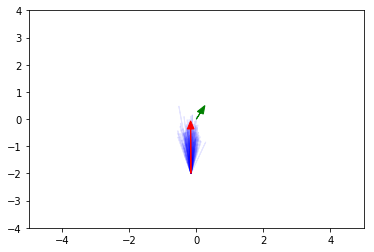

In [1042]:
mean_model.load_state_dict(best_models[2]['mean_model'])
std_model.load_state_dict(best_models[2]['var_model'])
mean_model.eval()
std_model.eval()
#rows = dataset.sample(n=1)
#row = rows.iloc[0]
#orig = dataset_.loc[row.name]
x = row[in_keys].values.astype(np.float32)
y = row[out_keys].values.astype(np.float32)
X = Variable(torch.from_numpy(x.reshape(1, -1)).cuda())
Y = Variable(torch.from_numpy(y.reshape(1, -1)).cuda())
plt.xlim(-5, 5)
plt.ylim(-4, 4)
µ = mean_model(oracle_norm(X))
σ = std_model(oracle_norm(X))
for _ in range(128):
    y_pred = oracle_norminv(µ + σ * Variable(torch.randn(σ.size()).cuda())).cpu().data.numpy().flatten()
    plt.arrow(row[0], row[1], y_pred[0], y_pred[1], color='blue', alpha=0.1)
plt.arrow(row[0], row[1], row[9], row[10], head_width=0.2, color='r')
plt.arrow(0, 0, row[6], row[7], head_width=0.2, color='g')
plt.show()

In [ ]:
#with open('oracle-3-units-256-hidden-mean.pkl', 'wb') as f:
#    pickle.dump(mean_model.state_dict(), f)

# Pushability
$$p(x_t'|x_t)$$

## Datasets

In [56]:
# sort in order
dataset_pushability = dataset[['y\'_0', 'y\'_1', 'y\'_2', 'm', 'I', 'µ', 'w', 'h']] # skip u_4 because always 0
dataset_pushability = dataset_pushability[(dataset_pushability[['y\'_0', 'y\'_1', 'y\'_2']].abs().max(axis=1) > 1e-1)]
# Decide where to split in training/validation/test
train_cut = int(len(dataset_pushability) * 0.9)
valid_cut = train_cut + int(len(dataset_pushability) * 0.05)
dataset_pushability_train_ = dataset_pushability[:train_cut]
dataset_pushability_val_ = dataset_pushability[train_cut:valid_cut]
dataset_pushability_test_ = dataset_pushability[valid_cut:]

## Normalize by training set statistics
training_pushability_µ = dataset_pushability_train_.mean().values.astype(np.float32)
training_pushability_σ = dataset_pushability_train_.std().values.astype(np.float32)
dataset_pushability_train = (dataset_pushability_train_ - training_pushability_µ) / training_pushability_σ
dataset_pushability_val = (dataset_pushability_train_ - training_pushability_µ) / training_pushability_σ
dataset_pushability_test = (dataset_pushability_train_ - training_pushability_µ) / training_pushability_σ

def get_dataloader(dataset, batch_size=32):
    X = dataset[[name for name in dataset.columns if not name.startswith('y\'')]]
    Y = dataset[[name for name in dataset.columns if name.startswith('y\'')]]
    return DataLoader(
        list(zip(X.as_matrix().astype(np.float32), Y.as_matrix().astype(np.float32))),
        batch_size=batch_size,
        shuffle=True
    )

dataloader_pushability_train = get_dataloader(dataset_pushability_train)
dataloader_pushability_val = get_dataloader(dataset_pushability_val, batch_size=512)
dataloader_pushability_test = get_dataloader(dataset_pushability_test, batch_size=512)
X, Y = next(iter(dataloader_pushability_train))
pushability_x_size, pushability_y_size = X.size(1), Y.size(1)

# Models:

In [29]:
n_residual_units = 1
hidden_size = 256
X, Y = next(iter(dataloader_pushability_train))
x_size = X.size(1)
y_size = Y.size(1)
print('X and Y sizes:', x_size, y_size)
pushability_mean = torch.nn.Sequential(
    torch.nn.Linear(x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, y_size)
).cuda()

pushability_std = torch.nn.Sequential(
    torch.nn.Linear(x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, y_size),
    torch.nn.Softplus()
).cuda()

X and Y sizes: 5 3


In [30]:
mean_loss_fn = torch.nn.MSELoss()
mean_optim = torch.optim.Adam(pushability_mean.parameters(), weight_decay=1e-4)
var_loss_fn = gaussian_likelihood()
var_optim = torch.optim.Adam(pushability_std.parameters(), weight_decay=1e-4)

logger_train = SummaryWriter('runs/resid-1-pushability-train')
logger_valid = SummaryWriter('runs/resid-1-pushability-valid')

In [31]:
best_val = np.inf
best_mean_model = None
best_var_model = None
step = 0
while True:
    for batch in dataloader_pushability_train:
        pushability_mean.train()
        pushability_std.train()
        X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), batch)
        Y_mean_pred = pushability_mean(X)
        Y_var_pred = pushability_std(X)

        pushability_mean.zero_grad()
        pushability_std.zero_grad()

        mse = mean_loss_fn(Y_mean_pred, Y)
        mse.backward(retain_graph=True)
        mean_optim.step()

        nll = var_loss_fn(Y_mean_pred, Y_var_pred, Y)
        nll.backward()
        var_optim.step()

        if step % 10 == 0:
            logger_train.add_scalar('mse', mse.cpu().data.numpy()[0], step)
            logger_train.add_scalar('nll', nll.cpu().data.numpy()[0], step)
            
            pushability_mean.eval()
            pushability_std.eval()
            val_batch = next(iter(dataloader_pushability_val))
            X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
            Y_mean_pred = pushability_mean(X)
            Y_var_pred = pushability_std(X)

            mse_val = mean_loss_fn(Y_mean_pred, Y)
            nll_val = var_loss_fn(Y_mean_pred, Y_var_pred, Y).cpu().data.numpy()[0]
            
            logger_valid.add_scalar('mse', mse_val.cpu().data.numpy()[0], step)
            logger_valid.add_scalar('nll', nll_val, step)
            
            if nll_val < best_val:
                best_val = nll_val
                best_mean_model = pushability_mean.state_dict()
                best_var_model = pushability_std.state_dict()

        step += 1
        if step >= 100000:
            break
    if step >= 100000:
        break

KeyboardInterrupt: 

In [71]:
X, Y = next(iter(dataloader_pushability_train))
pushability_x_size, pushability_y_size = X.size(1), Y.size(1)

pushability_norm = Normalization(5)
pushability_norm.mean = torch.from_numpy(training_pushability_μ[3:])
pushability_norm.std = torch.from_numpy(training_pushability_σ[3:])

pushability_norminv = NormalizationInverse(3)
pushability_norminv.mean = torch.from_numpy(training_pushability_μ[:3])
pushability_norminv.std = torch.from_numpy(training_pushability_σ[:3])

In [72]:
with open('./saved_models/pushability_models.pkl', 'wb') as f:
    model_dict = {
        'mean_model': pushability_mean.state_dict(),
        'std_model': pushability_std.state_dict(),
        'norm': pushability_norm.state_dict(),
        'norm_inv': pushability_norminv.state_dict(),
        'n_features_in': pushability_x_size,
        'n_features_out': pushability_y_size,
        'n_hidden_units': 256,
        'n_residual_units': 1,
    }
    pickle.dump(model_dict, f)

In [40]:
pushability_mean.eval()
pushability_std.eval()
pushability_mean.load_state_dict(best_mean_model)
pushability_std.load_state_dict(best_var_model)

from IPython.display import HTML
from matplotlib.animation import FuncAnimation
# First set up the figure, the axis, and the plot element we want to animate
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

res = 16
img = np.eye(res)
p1 = axs[0].imshow(img, extent=[-1, 1, -1, 1], vmin=0.0, vmax=0.5, interpolation='gaussian')
std1 = axs[0].add_artist(plt.Circle((0, 0), fill=False, color='white'))
std2 = axs[0].add_artist(plt.Circle((0, 0), fill=False, color='white'))
axs[0].set_title('Translation')
axs[2].set_title('Parameter')
axs[2].set_xlim(0, 32)
axs[2].set_ylim(0, 2.0)
θ_data = []
θ_plot, = axs[1].plot(θ_data)
axs[1].set_xlim(0, 32)
axs[1].set_ylim(0, 2)
axs[1].set_title('Rotation standard dev.')
ydata = []
argplot, = axs[2].plot(ydata)
    
# animation function. This is called sequentially
def animate(arg):
    x = (np.array([[0.35, 0.0024, 0.195 * arg * 2, 0.12, 0.12]]) - training_pushability_μ[3:]) / training_pushability_σ[3:]
    X = Variable(torch.from_numpy(x.astype(np.float32))).cuda()
    Y_mean_pred = pushability_mean(X).cpu().data.numpy()
    Y_std = pushability_std(X).cpu().data.numpy()
    
    µ = Y_mean_pred[0, :] * training_pushability_σ[:3] + training_pushability_μ[:3]
    σ = Y_std * training_pushability_σ[:3]
    Σ = np.diag(σ.flatten())

    obs = dataset_pushability_train.iloc[0].values[3:].reshape(-1, 1)
    obs[0, 0] = arg
    for i, x in enumerate(np.linspace(-1, 1, res)):
        for j, y in enumerate(np.linspace(-1, 1, res)):
            img[j, i] = multivariate_normal.pdf([x, y, 0], mean=µ.flatten(), cov=Σ)
    p1.set_data(img)
    σ_ = σ[0, :2].mean()
    std1.set_radius(σ_)
    std2.set_radius(σ_ * 2)
    ydata.append(arg)
    θ_data.append(σ[0, 2])
    argplot.set_data(range(len(ydata)), ydata)
    argplot.set_data(range(len(ydata)), ydata)
    θ_plot.set_data(range(len(θ_data)), θ_data)
    
    return p1, std1, std2, argplot, θ_plot

# call the animator. blit=True means only re-draw the parts that have changed.
anim = FuncAnimation(fig, animate, frames=np.linspace(0.0, 2.0, 32), interval=100, blit=True)
plt.close(fig)
HTML(anim.to_html5_video())

# Feasibility
Predicts $p(x_{robot}|x_{target}, x_{target}')$

In [1211]:
dataset_feasibility = dataset[['x_0', 'x_1', 'x_2', 'x_3',
                               'y_2', 'y_3', 'y\'_0', 'y\'_1', 'y\'_2',
                               'm', 'I', 'µ', 'w', 'h']]
# Decide where to split in training/validation/test
train_cut = int(len(dataset) * 0.9)
valid_cut = train_cut + int(len(dataset) * 0.05)
dataset_feasibility_train_ = dataset_feasibility[:train_cut]
dataset_feasibility_val_ = dataset_feasibility[train_cut:valid_cut]
dataset_feasibility_test_ = dataset_feasibility[valid_cut:]

# Normalize by training set statistics
training_feasibility_µ = dataset_feasibility_train_.mean()
training_feasibility_σ = dataset_feasibility_train_.std()
dataset_feasibility_train = (dataset_feasibility_train_ - training_feasibility_µ) / training_feasibility_σ
dataset_feasibility_val = (dataset_feasibility_train_ - training_feasibility_µ) / training_feasibility_σ
dataset_feasibility_test = (dataset_feasibility_train_ - training_feasibility_µ) / training_feasibility_σ

def get_dataloader(dataset, batch_size=32):
    X = dataset[[name for name in dataset.columns if not name.startswith('x')]]
    Y = dataset[[name for name in dataset.columns if name.startswith('x')]]
    return DataLoader(
        list(zip(X.as_matrix().astype(np.float32), Y.as_matrix().astype(np.float32))),
        batch_size=batch_size,
        shuffle=True
    )

dataloader_feasibility_train = get_dataloader(dataset_feasibility_train)
dataloader_feasibility_val = get_dataloader(dataset_feasibility_val, batch_size=128)
dataloader_feasibility_test = get_dataloader(dataset_feasibility_test, batch_size=128)
X, Y = next(iter(dataloader_feasibility_train))
feasibility_x_size, feasibility_y_size = X.size(1), Y.size(1)
dataset_feasibility_train.iloc[:10]

,x_0,x_1,x_2,x_3,y_2,y_3,y'_0,y'_1,y'_2,m,I,µ,w,h
1023237,0.059796,0.108608,1.380747,0.299016,-1.359581,-0.371693,-0.534314,2.790652,-1.568492,-1.242800,-0.943488,-1.045803,-1.252300,-1.078969
165346,-0.517012,-1.630013,-0.402372,1.354497,-0.525442,1.315233,0.002276,0.000444,1.076027,-0.415390,-0.649035,-0.632989,-0.845648,-0.689221
701472,1.148487,1.533910,1.410750,0.079207,-1.012441,-0.984590,0.002274,0.000444,-1.304842,-0.348302,0.556863,-1.045803,0.374308,0.480024
577533,0.339126,0.167986,1.405271,0.146665,-1.151245,-0.816157,-0.341511,-0.118533,1.568148,0.200782,1.142978,-0.632989,0.374308,0.480024
334895,-0.063637,-0.434472,-0.988990,-1.013749,-0.400139,-1.357908,0.036251,0.199168,1.671503,0.262941,-0.289961,0.192639,-0.288384,-0.876877
128454,2.074901,-1.092273,-1.144936,-0.833744,1.409104,0.107542,0.002276,0.000444,0.042447,-1.526058,-0.924287,-1.458617,0.163452,0.277932
916104,-0.972306,-1.171398,1.176328,-0.784471,-1.163615,-0.798246,0.002274,0.000444,-1.398276,0.632870,1.658115,-0.220175,0.374308,0.480024
910134,0.162860,-0.684146,-0.942569,-1.057006,-1.344953,0.423251,-0.360996,0.551321,1.503080,1.064958,2.173251,0.605453,0.374308,0.480024
622073,1.577501,0.385289,0.338118,1.371126,1.034094,0.967175,-0.063788,-0.012561,0.418069,1.157440,0.041317,0.605453,-0.288384,-0.876877
893662,-0.175802,0.106260,-1.073427,-0.923946,-1.274314,-0.603951,0.008716,-0.018471,-1.474244,1.604690,2.041557,1.431081,0.615287,-0.443824


# Models:

In [1215]:
hidden_size = 256
n_residual_units = 1

feasibility_mean = torch.nn.Sequential(
    torch.nn.Linear(feasibility_x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, feasibility_y_size)
).cuda()

feasibility_std= torch.nn.Sequential(
    torch.nn.Linear(feasibility_x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, feasibility_y_size),
    torch.nn.Softplus()
).cuda()

In [1216]:
weight_decay = 1e-4
mean_loss_fn = torch.nn.MSELoss()
mean_optim = torch.optim.Adam(feasibility_mean.parameters(), weight_decay=weight_decay)
std_loss_fn = gaussian_likelihood()
std_optim = torch.optim.Adam(feasibility_std.parameters(), weight_decay=weight_decay)

time_str = datetime.datetime.now().strftime('%H:%M')
name = 'runs/feasibility'
logger_train = SummaryWriter(name + '-train')
logger_valid = SummaryWriter(name + '-valid')

In [1217]:
best_val = np.inf
best_mean_model = None
best_std = None
step = 0
for _ in range(1024):
    for batch in dataloader_feasibility_train:
        feasibility_mean.train()
        feasibility_std.train()
        X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), batch)
        Y_mean_pred = feasibility_mean(X)
        Y_std_pred = feasibility_std(X)

        feasibility_mean.zero_grad()
        feasibility_std.zero_grad()

        mse = mean_loss_fn(Y_mean_pred, Y)
        mse.backward(retain_graph=True)
        mean_optim.step()

        nll = std_loss_fn(Y_mean_pred, Y_std_pred, Y)
        nll.backward()
        std_optim.step()

        if step % 500 == 0:
            logger_train.add_scalar('mse', mse.cpu().data.numpy()[0], step)
            logger_train.add_scalar('nll', nll.cpu().data.numpy()[0], step)
            
            feasibility_mean.eval()
            feasibility_std.eval()
            val_batch = next(iter(dataloader_feasibility_val))
            X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
            Y_mean_pred = feasibility_mean(X)
            Y_std_pred = feasibility_std(X)

            mse_val = mean_loss_fn(Y_mean_pred, Y)
            nll_val = std_loss_fn(Y_mean_pred, Y_std_pred, Y).cpu().data.numpy()[0]
            
            logger_valid.add_scalar('mse', mse_val.cpu().data.numpy()[0], step)
            logger_valid.add_scalar('nll', nll_val, step)
            
            if nll_val < best_val:
                best_val = nll_val
                best_mean_model = feasibility_mean.state_dict()
                best_std_model = feasibility_std.state_dict()

        step += 1

KeyboardInterrupt: 

In [1218]:
feasibility_norm = Normalization(feasibility_x_size).cuda()
feasibility_norm.mean = torch.FloatTensor(training_feasibility_μ[4:].values).cuda()
feasibility_norm.std = torch.FloatTensor(training_feasibility_σ[4:].values).cuda()
feasibility_norminv = Normalization(feasibility_y_size).cuda()
feasibility_norminv.mean = torch.FloatTensor(training_feasibility_μ[:4].values).cuda()
feasibility_norminv.std = torch.FloatTensor(training_feasibility_σ[:4].values).cuda()

x_0    -0.051210
x_1     0.393378
x_2     0.825997
x_3    -0.563675
y_2    -0.972441
y_3    -0.233147
y'_0    0.277912
y'_1   -0.819914
y'_2   -0.201949
u_0    -0.349121
u_1    -1.177300
u_2    -1.002050
u_3     0.704964
m       0.410000
I       0.004619
µ       0.086000
w       0.130000
h       0.130000
Name: 438395, dtype: float64


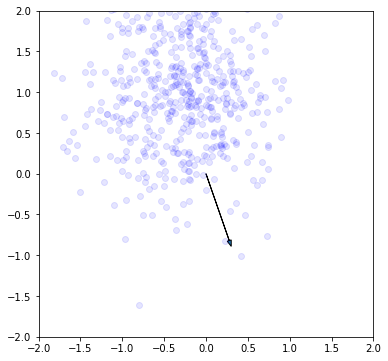

In [1242]:
from matplotlib.patches import Ellipse

feasibility_mean.load_state_dict(best_mean_model)
feasibility_std.load_state_dict(best_std_model)
feasibility_mean.eval()
feasibility_std.eval()

#with open('./saved_models/feasibility_models.pkl', 'wb') as f:
#    model_dict = {
#        'mean_model': feasibility_mean.state_dict(),
#        'std_model': feasibility_std.state_dict(),
#        'norm': feasibility_norm.state_dict(),
#        'norm_inv': feasibility_norminv.state_dict(),
#        'n_features_in': feasibility_x_size,
#        'n_features_out': feasibility_y_size,
#        'n_hidden_units': 256,
#        'n_residual_units': 1,
#    }
#    pickle.dump(model_dict, f)

fig, ax = plt.subplots(figsize=(6, 6))
row = dataset.sample(n=1).iloc[0]
#val_batch = next(iter(dataloader_feasibility_val))
print(row)
X = Variable(torch.cuda.FloatTensor([
    row[['y_2', 'y_3', 'y\'_0', 'y\'_1', 'y\'_2', 'm', 'I', 'µ', 'w', 'h']]
]))
#X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
Y_mean_pred = feasibility_mean(feasibility_norm(X))
Y_std_pred = feasibility_std(feasibility_norm(X))
for _ in range(512):
    y_ = feasibility_norminv(Y_mean_pred + Y_std_pred * Variable(torch.randn(Y_mean_pred.size())).cuda())
    y = y_.cpu().data.numpy().flatten()
    plt.plot(y[0], y[1], 'bo', alpha=0.1)
plt.arrow(0, 0, row['y\'_0'], row['y\'_1'], head_width=0.05)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

In [ ]:
training_µ